# Assignment: Mushroom Cultivation - Bayesian Analysis

**Authors** : Carnio, Gritti

**Course**  : Bayesian Data Analysis and Probabilistic Programming


## Problem Statement

A mushroom farm is testing how different storage temperatures affect the spoilage rate of harvested oyster mushrooms. We analyze experimental data from 4 temperature levels to model the relationship between temperature and spoilage probability using Bayesian logistic regression.

---

# 0. Preparation
## 0.1 Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import expit
from scipy.stats import norm
from scipy.optimize import minimize

import arviz as az
from tqdm import tqdm

np.random.seed(42)

## 0.2 Dataset

In [2]:
df = pd.DataFrame({
    'StorageTemperature': [2, 8, 15, 25],
    'TotalMushrooms': [30,25,20,30],
    'SpoiledMushrooms': [2,4,5,20]
})
df

,StorageTemperature,TotalMushrooms,SpoiledMushrooms
0,2,30,2
1,8,25,4
2,15,20,5
3,25,30,20


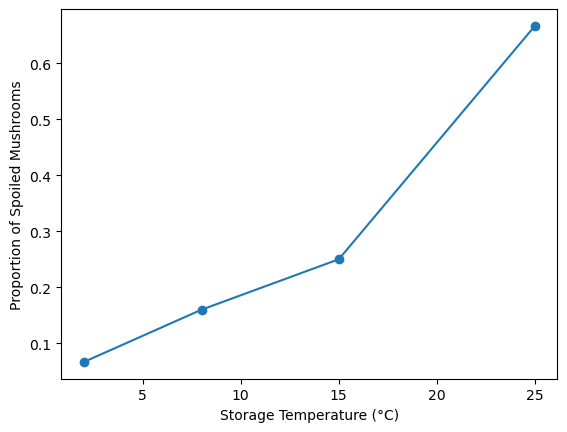

In [3]:
x = df['StorageTemperature'].values
y = df['SpoiledMushrooms'].values
p = y / df['TotalMushrooms'].values
plt.figure()
plt.plot(x, p, 'o-')
plt.xlabel('Storage Temperature (°C)')
plt.ylabel('Proportion of Spoiled Mushrooms')
plt.show()

The plots show the relationship between storage temperature and mushroom spoilage. The relationship looks roughly linear, with higher temperatures leading to a higher proportion of spoiled mushrooms.

## 0.3 Modeling Assumptions

1. The outcome of the \($n_i$\) mushrooms within each group \(i\) are *independent*.  
   Each mushroom in the group has probability \($p_i$\) of spoilage.

2. The probability \($p_i$\) that a mushroom spoils depends on the temperature level \($x_i$\) as follows:

   $$
   p_i = \text{sigm}(\alpha + \beta x_i)
   $$

   where

   $$
   \text{sigm}(z) = \frac{1}{1 + e^{-z}}
   $$

3. The parameters $\theta = [\alpha, \beta]^\top$ have independent Gaussian priors:
   \begin{align}
   \alpha &\sim \mathcal{N}(\mu_\alpha, \sigma_\alpha^2), \quad \mu_\alpha = 0, \sigma_\alpha = 2 \\
   \beta &\sim \mathcal{N}(\mu_\beta, \sigma_\beta^2), \quad \mu_\beta = 0, \sigma_\beta = 1
   \end{align}

4. The outcomes in the four groups are independent of each other, given $𝜃$.

---

# 1. Probabilistic Model

## 1.1 Derive and comment the full probabilistic model

### Bayesian Logistic Regression Model

We model the spoilage of mushrooms based on storage temperature.

#### Variables
* $i$: Index for the experimental group.
* $n_i$: Total number of mushrooms in group $i$.
* $y_i$: Number of spoiled mushrooms in group $i$.
* $x_i$: Temperature level for group $i$.

#### Likelihood
The outcome of the $n_i$ mushrooms within each group $i$ is independent. The number of spoiled mushrooms follows a Binomial distribution:

$$y_i \sim \text{Binomial}(n_i, p_i)$$
where $p_i$ is the probability of spoilage in group $i$ and $n_i$ is the total number of mushrooms in group $i$.

The probability $p_i$ that a mushroom spoils depends on the temperature $x_i$ so we can model the log odds of spoilage as a linear function of temperature:

$$\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}$$

In our case:
$$p_i = \text{sigmoid}(\alpha + \beta x_i) = \frac{1}{1 + e^{-(\alpha + \beta x_i)}}$$

#### Prior
The parameters $\theta = [\alpha, \beta]^\top$ have independent Gaussian priors:

$$ \alpha \sim \mathcal{N}(0, 2^2) $$
$$ \beta \sim \mathcal{N}(0, 1^2) $$

**Derivation of the joint prior density:**
Due to independence, the joint prior density is the product of the individual priors:
$$ f(\theta) = f(\alpha, \beta) = f(\alpha) \cdot f(\beta)$$

Moreover, given $ (\alpha, \beta) $ the outcomes in the four groups are independent of each other.

$$
P(\mathbf{y} \mid \alpha, \beta) = \prod_{i=1}^4 P(y_i \mid n_i, x_i, \alpha, \beta)
$$

Substituting the standard normal PDF formula $$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$ with our specific hyperparameters ($\sigma_\alpha=2, \sigma_\beta=1, \mu=0$):

$$ \begin{aligned}
f(\alpha, \beta) &= \left( \frac{1}{\sqrt{2\pi \cdot 4}} e^{-\frac{\alpha^2}{2 \cdot 4}} \right) \cdot \left( \frac{1}{\sqrt{2\pi \cdot 1}} e^{-\frac{\beta^2}{2 \cdot 1}} \right) \\
&= \left( \frac{1}{2\sqrt{2\pi}} \cdot \frac{1}{\sqrt{2\pi}} \right) \cdot \exp\left( -\frac{\alpha^2}{8} - \frac{\beta^2}{2} \right) \\
&= \frac{1}{4\pi} \exp\left( \frac{-\alpha^2}{8} - \frac{4\beta^2}{8} \right)
\end{aligned}
$$

**Final Joint Prior:**
$$
f(\alpha, \beta) = \frac{1}{4\pi} \exp \left( -\frac{\alpha^2 + 4\beta^2}{8} \right)
$$

---

# 1.2 Maximum Likelihood Estimation

## 1.2.1 Derive an analytical expression of the likelihood function $\mathcal{L}(\theta) = P(y|\theta)$

The total likelihood function is just the product of the likelihoods of each group:

$$
\mathcal{L}(\vec{\theta}) = \prod_{i=1}^{4} \binom{n_i}{y_i} \cdot p_i^{y_i} \cdot (1-p_i)^{n_i-y_i}
$$


For each group $i$, the likelihood of observing $y_i$ spoiled mushrooms out of $n_i$ given the spoilage probability $p_i$ is given by the Binomial distribution formula

Substituting $p_i = \mathrm{sigm}(\alpha + \beta x_i)$:

$$
= \prod_{i=1}^{n} \binom{n_i}{y_i} \cdot \mathrm{sigm}(\alpha + \beta x_i)^{y_i} \cdot [1-\mathrm{sigm}(\alpha + \beta x_i)]^{n_i-y_i}
$$


$$
\propto \prod_{i=1}^{n} \mathrm{sigm}(\alpha + \beta x_i)^{y_i} \cdot [1-\mathrm{sigm}(\alpha + \beta x_i)]^{n_i-y_i}
$$

We can ignore the binomial coefficients $\binom{n_i}{y_i}$ since they do not depend on the parameters $\theta = [\alpha, \beta]^\top$ and thus do not affect the location of the maximum likelihood estimate.
They do not depend because they are constants with respect to $\alpha$ and $\beta$.

n is the number of groups (4 in this case) NOT the number of samples.

## 1.2.2 Derive an analytical expression of the log-likelihood function $\ell(\theta)$

Multiplying several probability mass function leads to very small numbers that can cause numerical underflow, using the log-likelihood we ensure numerical stability, in fact a log of a product becomes a sum which ensures we don't go towards zero.

Moreover, it is often easier to maximize an analytical expression using the logarithm since it is monotonically increasing, maximizing $f(x)$ is equivalent to maximize $\log(f(x))$ - the location of the maximum doesn't change.

$$
\begin{aligned}
\ell(\vec{\theta}) &= \log \mathcal{L}(\vec{\theta}) \\
&= \sum_{i=1}^{4} \log\left[ \binom{n_i}{y_i} \cdot \mathrm{sigm}(\alpha + \beta x_i)^{y_i} \cdot (1-\mathrm{sigm}(\alpha + \beta x_i))^{n_i-y_i} \right] \\
&= \sum_{i=1}^{4} \left[ \log \binom{n_i}{y_i} + y_i \log(\mathrm{sigm}(\alpha + \beta x_i)) + (n_i-y_i) \log(1-\mathrm{sigm}(\alpha + \beta x_i)) \right] \\
&\propto \sum_{i=1}^{4} \left[ y_i \log(\mathrm{sigm}(\alpha + \beta x_i)) + (n_i-y_i) \log(1-\mathrm{sigm}(\alpha + \beta x_i)) \right]
\end{aligned}
$$

Note: We use $i=1$ to $4$ since we have 4 temperature groups, and the correct functional form is $\alpha + \beta x_i$ (intercept + slope × temperature).

## 1.2.3 Python implementation of log-likelihood function

In [4]:
def sigmoid(z):
    #return 1/(1 + np.exp(-z))
    
    #using expit due to the fact that the "naive" form of the sigmoid (the one above)
    #may cause numerical overflow during the Metropolis, therefore obtaining
    #infinite log-likelihoods and bias in sampling; using expit is more stable
    return expit(z)

In [5]:
def likelihood(alpha, beta):
    x_vals = df['StorageTemperature'].values
    n_vals = df['TotalMushrooms'].values
    y_vals = df['SpoiledMushrooms'].values
    likelihood_val = 1.0
    for i in range(len(x_vals)):
        p_i = sigmoid(alpha + beta * x_vals[i])
        #we clip p_i to avoid numerical issues
        p_i = np.clip(p_i, 1e-15, 1-1e-15)
        likelihood_val *= (p_i**y_vals[i]) * ((1 - p_i)**(n_vals[i] - y_vals[i]))

    return likelihood_val

def log_lik(alpha, beta):
    x_vals = df['StorageTemperature'].values
    n_vals = df['TotalMushrooms'].values
    y_vals = df['SpoiledMushrooms'].values
    log_lik_val = 0.0
    for i in range(len(x_vals)):
        p_i = sigmoid(alpha + beta * x_vals[i])
        p_i = np.clip(p_i, 1e-15, 1-1e-15)

        log_lik_val += y_vals[i] * np.log(p_i) + (n_vals[i] - y_vals[i]) * np.log(1 - p_i)
    return log_lik_val

alpha_test, beta_test = 0, 0.1
lik_val = likelihood(alpha_test, beta_test)
log_lik_val = log_lik(alpha_test, beta_test)
if np.isclose(np.log(lik_val), log_lik_val): 
    # np.isclose uses both absolute and relative 
    # tolerance to compare floating point numbers
    # usually up until 10^-8 for small floating point numbers
    print("The two functions are consistent")

The two functions are consistent


## 1.2.4 Visualize likelihood and log-likelihood functions

First we create a grid of alpha and beta values to evaluate the log-likelihood and the likelihood function over a range of parameter values. This will help us visualize how the log-likelihood varies with different combinations of alpha and beta.

In [6]:
def create_meshgrid(alpha_range=(-5,1),beta_range=(-20,20), step=0.1):
    alpha_vals=np.arange(alpha_range[0],alpha_range[1], step)
    beta_vals=np.arange(beta_range[0], beta_range[1], step)
    #we use meshgrid to create a grid in a convenient way
    # alpha_prior and beta_prior are 2D arrays where each (i,j) element corresponds to a pair (alpha, beta)
    # this is useful for evaluating functions over a grid of parameter values
    # but also for plotting
    a_prior, b_prior = np.meshgrid(alpha_vals, beta_vals)
    return a_prior, b_prior

def create_grid_from_function(func, alpha_grid, beta_grid):
  g = np.zeros_like(alpha_grid)
  for i in range(alpha_grid.shape[0]):
    for j in range(alpha_grid.shape[1]):
      a, b = alpha_grid[i, j], beta_grid[i, j]
      g[i, j] = func(a, b)
  return g

In [7]:
def display_distribution(func, alpha_g, beta_g, func_name=''):
    grid = create_grid_from_function(func, alpha_g, beta_g)
    plt.imshow(grid[::-1], extent=(alpha_g.min(), alpha_g.max(), beta_g.min(), beta_g.max()), origin='lower', aspect='auto')
    # extent allows to set the axis limits correctly
    # also we need to invert the grid because imshow starts the y-axis from the top, 
    # that means that the first row is the highest value of beta, while in our meshgrid it's the lowest.
    plt.colorbar()
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.title(f'Distribution: {func_name}')
    plt.show()


The functions above are not optimized for large inputs, if we want to work with large grids we should vectorize them or use numpy functions directly. But for purpose of understanding the relationship between likelihood and log-likelihood this is sufficient.

### Likelihood Visualization

I expect alpha that represent the intercept should be tuned around negative values because usually as we go lower in temperature we have low spoilage.
For the beta that represent the slope we should have a low increase in spoilage so a good fit is betwen 0 and 1

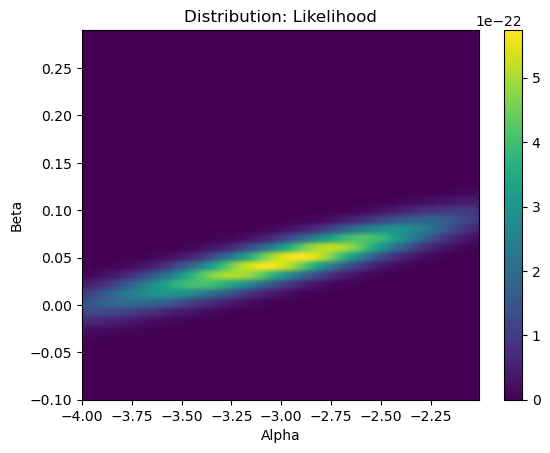

In [8]:
a_prior_small, b_prior_small = create_meshgrid(alpha_range=(-4, -2), beta_range=(-0.1, 0.3), step=0.01)
display_distribution(likelihood, a_prior_small, b_prior_small, func_name='Likelihood')

The likelihood plot shows wave like patterns because we're working with very small numbers, in fact we're hitting numerical precision limits that leads to numerical underflow. This makes it difficult to interpret the likelihood surface and identify the maximum likelihood estimates.

### Log-Likelihood Visualization

In [9]:
step_log = 0.001
a_prior_log, b_prior_log = create_meshgrid(alpha_range=(-6, -1), beta_range=(-0.2, 0.5), step=step_log)

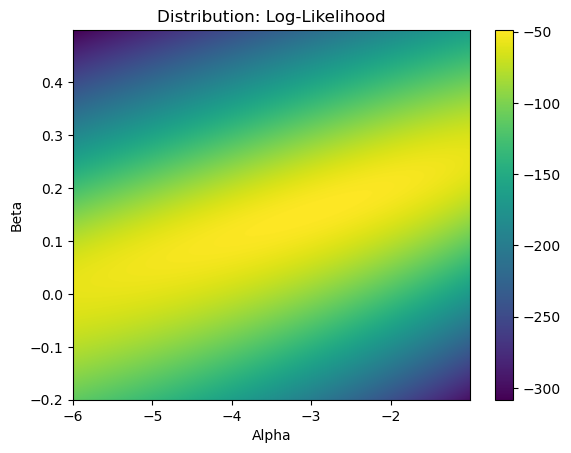

In [10]:
display_distribution(log_lik, a_prior_log, b_prior_log, func_name='Log-Likelihood')

The log likelihood plot is smoother and more interpretable than the likelihood plot. The log transformation helps to mitigate the numerical issues seen in the likelihood plot, making it easier to identify the region of maximum likelihood.

### Prior Visualization

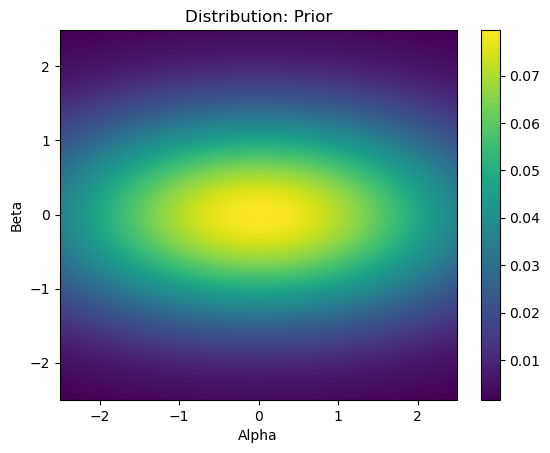

In [11]:
a_prior_standard, b_prior_standard = create_meshgrid(alpha_range=(-2.5,2.5), beta_range=(-2.5, 2.5), step=0.01)

def prior(a, b):
    return (1 / (4 * np.pi)) * np.exp(-(a**2 + 4 * b**2) / 8)

prior_grid = display_distribution(prior, a_prior_standard, b_prior_standard, func_name='Prior')    

The prior is mildly informative, centering around (0,0) with lower variance along the beta axis, reflecting our belief that the slope of the relationship between temperature and spoilage is likely to be small.

## 1.2.5 Compute Maximum Likelihood estimates

When finding the ML estiamates we compute the paramaters that mostly generates the observed data.


maximum Likelihood Estimates:
alpha: -3.0000
beta: 0.1000
maximum likelihood: 0.0000


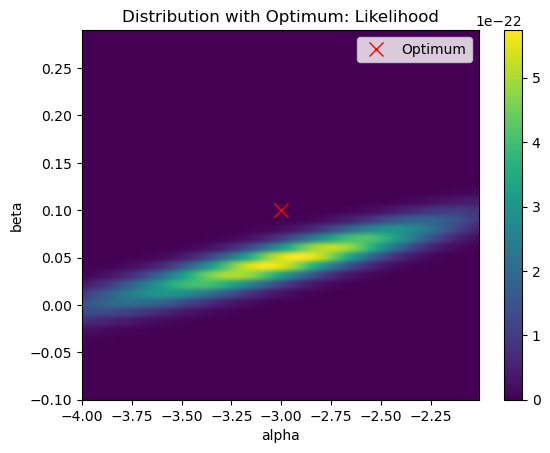

In [12]:
def optimize_function(func, initial_guess):
    result = minimize(func, initial_guess)
    #.x contains the parameters that minimize the function
    #.fun contains the value of the function at the optimum
    return result.x, result.fun

def display_distribution_with_optimum(func, alpha_g, beta_g, optimum, func_name=''):
    grid = create_grid_from_function(func, alpha_g, beta_g)
    plt.figure()
    #we use the extent using the min and max of the grid to have the correct axis limits
    plt.imshow(grid[::-1], extent=(alpha_g.min(), alpha_g.max(), beta_g.min(), beta_g.max()), origin='lower', aspect='auto')
    plt.colorbar()
    plt.xlabel('alpha')
    plt.ylabel('beta')
    plt.title(f'Distribution with Optimum: {func_name}')
    plt.plot(optimum[0], optimum[1], 'rx', markersize=10, label='Optimum')
    plt.legend()
    plt.show()

initial_guess = [-3, 0.1]
opt_lik_params, opt_lik_value = optimize_function(lambda params: -likelihood(params[0], params[1]), initial_guess)

print(f"maximum Likelihood Estimates:")
print(f"alpha: {opt_lik_params[0]:.4f}")
print(f"beta: {opt_lik_params[1]:.4f}")
print(f"maximum likelihood: {-opt_lik_value:.4f}")

display_distribution_with_optimum(likelihood, a_prior_small, b_prior_small, opt_lik_params, func_name='Likelihood')
print()

Trying to optimizing the likelihood directly can be numerically unstable due to the very small values involved, leading to underflow issues. Therefore, we chose to optimize the log-likelihood instead, which transforms products into sums and helps maintain numerical stability. However there might still a method to optimize the likelihood directly using log-sum-exp trick or other numerical techniques to handle small values.

## 1.2.6 Visualize likelihood function with ML estimate

maximum Likelihood Estimates:
alpha: -2.9776
beta: 0.1439
maximum log-likelihood: -48.9011


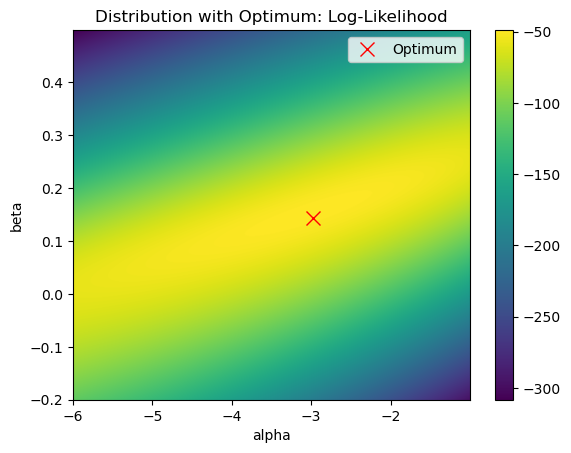

In [13]:
initial_guess = [0, 0]
opt_lik_params, opt_lik_value = optimize_function(lambda params: -log_lik(params[0], params[1]), initial_guess)

print(f"maximum Likelihood Estimates:")
print(f"alpha: {opt_lik_params[0]:.4f}")
print(f"beta: {opt_lik_params[1]:.4f}")
print(f"maximum log-likelihood: {-opt_lik_value:.4f}")

step_log = 0.001
display_distribution_with_optimum(log_lik, a_prior_log, b_prior_log, opt_lik_params, func_name='Log-Likelihood')
print()

The optimization yields good results.
The optimum alpha at -2.9 means that a 0 degrees celsius for the storage temperature results in a low log-odds of spoilage, which is consistent with the expectation that lower temperatures reduce spoilage risk.
The beta optimum at 0.14 means that for each 1 degree celsius the log-odds of spoilage increase by 0.14.
To find the real probabilities we can apply the sigmoid function to these log-odds values.
**The maxium likelyhood estimates at -48 means** that at the spoilage probability is very low at 0 degrees celsius.


In [14]:
alpha_optimal = opt_lik_params[0]
beta_optimal = opt_lik_params[1]
real_prob = sigmoid(alpha_optimal) #beta is 0 so we take only alpha
print(f"Spoilage probability at 0°C {real_prob*100}%")

real_prob_25 = sigmoid(alpha_optimal + beta_optimal*25)
print(f"Spoilage probability at 25°C {real_prob_25*100}%")

Spoilage probability at 0°C 4.844970724988596%
Spoilage probability at 25°C 65.02135940540742%


In [15]:
def display_distribution_with_two_optima(func1, alpha_g, beta_g, opt1, opt2, func_name1, func_name2):
    grid1 = create_grid_from_function(func1, alpha_g, beta_g)
    plt.figure()
    plt.imshow(grid1[::-1], extent=(alpha_g.min(), alpha_g.max(), beta_g.min(), beta_g.max()), origin='lower', aspect='auto')
    plt.colorbar()
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.title(f'Distribution with Optima: {func_name1} and {func_name2}')
    plt.plot(opt1[0], opt1[1], 'rx', markersize=10, label=f'Optimum {func_name1}')
    plt.plot(opt2[0], opt2[1], 'go', markersize=10, label=f'Optimum {func_name2}')
    plt.legend()
    plt.show()

---

# 1.3 Maximum A Posteriori Estimation

## 1.3.1 Derive analytical expression of posterior $f(\theta|y)$

We can use the bayes theorem to derive the posterior distribution of the parameters given the data:

$$
f(\theta | y) \propto \mathcal{L}(\theta) \cdot f(\theta)
$$

Substituting the expressions for the likelihood and the prior, note that we can ignore the binomial coefficients in the likelihood since they do not depend on $\theta$:
$$

f(\theta | y) \propto \prod_{i=1}^{n} \mathrm{sigm}(\alpha + \beta x_i)^{y_i} \cdot [1-\mathrm{sigm}(\alpha + \beta x_i)]^{n_i-y_i} \\
 \cdot \frac{1}{4\pi} \exp \left( -\frac{\alpha^2 + 4\beta^2}{8} \right)


$$




## 1.3.2 Derive analytical expression of log-posterior $g(\theta)=\log f(\theta|y)$



We start by taking the posterior from the previous point and then taking the logarithm:

$$
\begin{aligned}
g(\theta) = \log f(\theta|y) &= \sum_{i=1}^{4} \left[ y_i \log(\mathrm{sigm}(\alpha + \beta x_i)) + (n_i-y_i) \log(1-\mathrm{sigm}(\alpha + \beta x_i)) \right] \\
&\quad + \log\left(\frac{1}{4\pi}\right) - \frac{\alpha^2 + 4\beta^2}{8}
\end{aligned}
$$

We can ignore $\log(1/4\pi)$ because it is a constant with respect to $\theta$.

$$
g(\theta) \propto \sum_{i=1}^{4} \left[ y_i \log(\mathrm{sigm}(\alpha + \beta x_i)) + (n_i-y_i) \log(1-\mathrm{sigm}(\alpha + \beta x_i)) \right] - \frac{\alpha^2 + 4\beta^2}{8}
$$

This final formula repersents the **log-likelihood** plus the **log-prior**.

## 1.3.3 Python implementation of unnormalized log-posterior

The log-posterior function combines the log-likelihood and the log-prior, providing a comprehensive measure of how well the parameters explain the observed data while incorporating prior beliefs about the parameters.

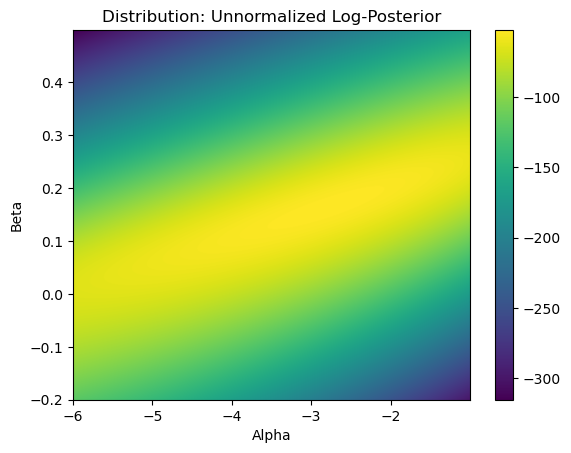

In [16]:
# the implemetation takes the log-likelihood and the log-prior
# since we have the defined just the prior previously we use np.log to get the log-prior
def unnormalized_log_posterior(alpha, beta):
    return log_lik(alpha, beta) + np.log(prior(alpha, beta))
display_distribution(unnormalized_log_posterior, a_prior_log, b_prior_log, func_name='Unnormalized Log-Posterior')


## 1.3.4 Compute Maximum A Posteriori estimates

To compute the maxium a posteriori estimates we optimize the log-posterior function derived previously.

In [17]:
initial_guess = [-3,0.1]
opt_map_params, opt_map_value = optimize_function(lambda params: -unnormalized_log_posterior(params[0], params[1]), initial_guess)
    
print(f"Aplha MAP estimate: {opt_map_params[0]}")
print(f"Beta MAP estimate: {opt_map_params[1]}")
print(f"MAP estimate: {opt_map_value}")

Aplha MAP estimate: -2.770704802347703
Beta MAP estimate: 0.13384979524595514
MAP estimate: 52.4716388487085


The alpha MAP estimate at -2.77 is slightly higher than the ML estimate of -2.97, reflecting the influence of the prior which pulls the estimate towards zero.
The beta MAP estimate at 0.13 is also slightly lower than the ML estimate of 0.14, again showing the prior's effect in regularizing the estimate.
The MAP estimate is slighly higher than the ML estimate, indicating that the prior has a modest influence on the parameter estimates in this case.


## 1.3.5 Visualize MAP and ML estimates with unnormalized posterior

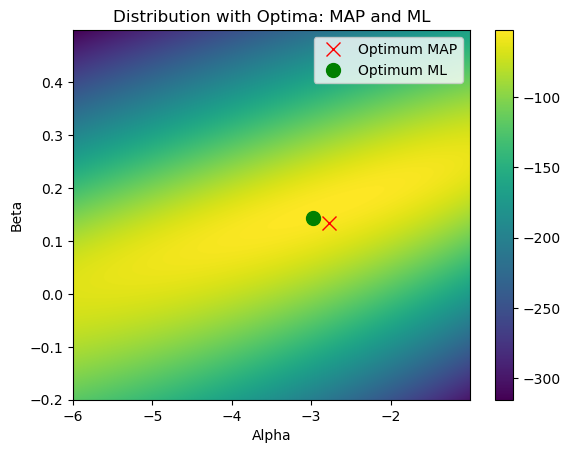

In [18]:
opt_ml_params, opt_ml_value = optimize_function(lambda params: -log_lik(params[0], params[1]), initial_guess)
display_distribution_with_two_optima(unnormalized_log_posterior, a_prior_log, b_prior_log, opt_map_params, opt_ml_params, 'MAP', 'ML')

The MAP estimate incorporates both the observed data and our prior beliefs about the parameters (maximising log-posterior). In contrast, the ML estimate relies solely on the observed data.(maximizing likelihood)

posterior ∝ likelihood × prior
$$ f(\theta | y) \propto \mathcal{L}(\theta) \cdot f(\theta) $$

MAP and ML estimate are close, this means that the prior has little influence because the data dominates.

So the less the informative the prior the less the influence on the posterior, so we rely more on the data. In this case the prior is mildly informative so it has some influence.

To remind ourselves, the MAP is bayesian and ML is frequentist.

---

# 1.4 Brute-force Posterior Estimation

## 1.4.1 Compute gridding approximation of normalized posterior

We perform gridding because it allows us to approximate the posterior distribution over a grid of paramter values. By evaluating the unnormalized posterior at discrete points in the parameter space, we can estimate the shape of the posterior distribution without relying on complex analytical solutions or sampling methods.

To go from the log-posterior to posterior we can just exponentiate the log-posterior values. However, if we want ensure numerical stability, we can substract the maximum log-posterior value from all log-posterior values before exponentiating. This prevents very large exponentials that can lead to overflow. In this way we do numerical normalization, in fact we ensure the maxium value of the exponentiated values is 1.



In [19]:
log_unnormalized_post_grid = create_grid_from_function(unnormalized_log_posterior, a_prior_log, b_prior_log)

# we just shift to ensure we work in a numerical stable range 
unnorm_post = np.exp(log_unnormalized_post_grid - np.max(log_unnormalized_post_grid))

Up until now we calculated the posterior without normalizing it. PDFs integrates to 1 over the parameter space and gridding serves this purpose well because it approximates the integral using a discrete sum over the grid points.
If we sum the unnormalized posterior we get this:


In [20]:
np.sum(unnorm_post)

np.float64(43932.677655529566)

We calculate the normalized posterior by integrating over the paramater space. This pdf tells the probability of observing the data under our model considering every possible combination of parameters weighted by how much was plausible a priori.

We define C as the normalizing constant


\begin{align*}
\int_{\vec{\theta}} \frac{1}{C} f(\vec{\theta}) \cdot \mathcal{L}(\vec{\theta}) \, d\vec{\theta} &= 1 \\
\iff\; C = \int_{\vec{\theta}} f(\vec{\theta}) \cdot \mathcal{L}(\vec{\theta}) \, d\vec{\theta} \\
\iff\; C = \int_\alpha \int_\beta f(\alpha, \beta) \cdot \mathcal{L}(\alpha, \beta) \, d\beta \, d\alpha
\end{align*}

## 1.4.2 Compute marginal posterior distributions of α and β

In [21]:
#we compute the normalization constant C |
# by summing the unnormalized posterior and multiplying by the area of each grid cell

C = np.sum(unnorm_post) * step_log * step_log 
print(f"Normalization constant C: {C}")

Normalization constant C: 0.043932677655529564


Now the marginal distributions can be computed by summing the normalized posterior over the other parameter axis. This gives us the distribution of each parameter independently, integrating out the uncertainty in the other parameter.
The marginal of alpha shows uncertainty in baseline spoilage (intercept)
The marginal of beta shows uncertainty in the effect of temperature on spoilage (slope)

posterior integrates to: 1.0000000000000002
marginal alpha integrates to: 0.9999999999999999
marginal beta integrates to: 1.0


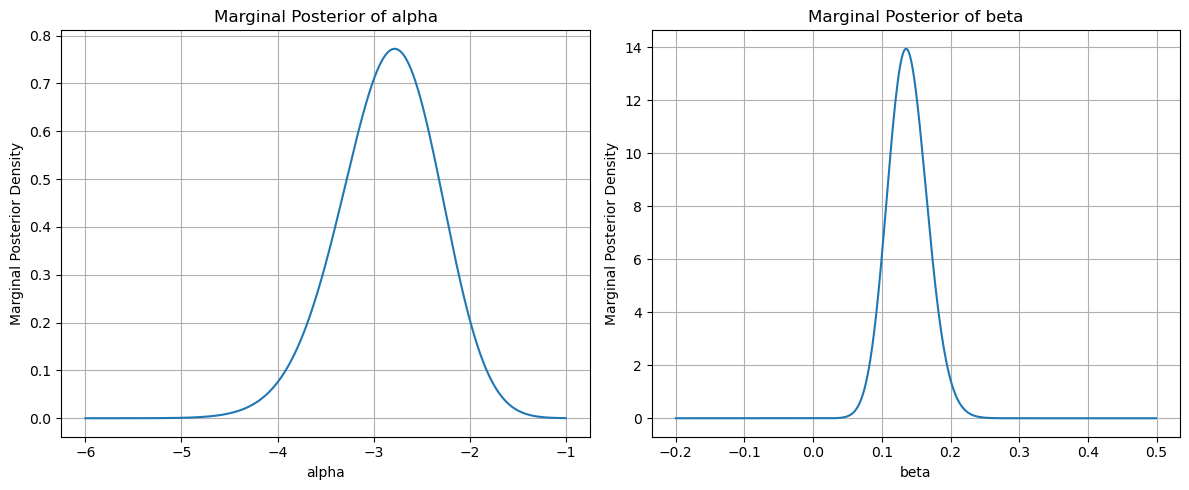

In [22]:
norm_post = unnorm_post / C
print(f"posterior integrates to: {np.sum(norm_post) * step_log * step_log}")

# we compute the marginal distributions by integrating 
# step log is the discrete step size in the grid
marginal_alpha = np.sum(norm_post, axis=0) * step_log #axis=0 corresponds to beta
marginal_beta = np.sum(norm_post, axis=1) * step_log #axis=1 corresponds to alpha
#marginal_alpha includes all values of alpha

#we sum the marginals to check they integrate to 1
print(f"marginal alpha integrates to: {np.sum(marginal_alpha) * step_log}")
print(f"marginal beta integrates to: {np.sum(marginal_beta) * step_log}")
alpha_grid_1d = a_prior_log[0, :]  # alpha values
beta_grid_1d = b_prior_log[:, 0]   # beta values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alpha_grid_1d, marginal_alpha)
plt.xlabel('alpha')
plt.ylabel('Marginal Posterior Density')
plt.title('Marginal Posterior of alpha')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(beta_grid_1d, marginal_beta)
plt.xlabel('beta')
plt.ylabel('Marginal Posterior Density')
plt.title('Marginal Posterior of beta')
plt.grid(True)
plt.tight_layout()
plt.show()

Now the posterior is actually a proper probability distribution over the parameter space.

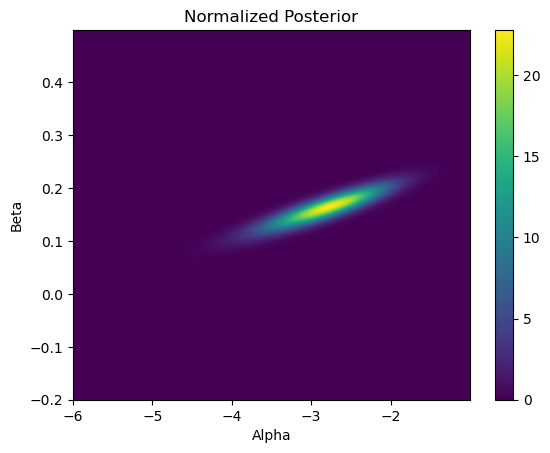

In [23]:
plt.imshow(norm_post[::-1], extent=(a_prior_log.min(), a_prior_log.max(), b_prior_log.min(), b_prior_log.max()), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Normalized Posterior')
plt.show()

## 1.4.3 Compute posterior mean using grid-based approximation

We must rewrite the formula for the posterior mean in terms of a summation over the grid points:
\begin{align*}
E[\theta] &= \int_{\vec{\theta}} \vec{\theta} \cdot f(\vec{\theta}|y) \, d\vec{\theta} \\
&\approx \sum_{\theta} \vec{\theta} \cdot f(\vec{\theta}|y) \cdot \Delta \theta
\end{align*}

we multiply by $\vec{\theta}$ because we want the expected value of the parameter, so we weight each parameter value by its posterior probability.

In [24]:
grid_post_alpha_mean = np.sum(a_prior_log * norm_post) * step_log * step_log
grid_post_beta_mean = np.sum(b_prior_log * norm_post)  * step_log * step_log

print(f'Posterior mean of alpha: {grid_post_alpha_mean}')
print(f'Posterior mean of beta: {grid_post_beta_mean}')

Posterior mean of alpha: -2.8462546331194436
Posterior mean of beta: 0.13770177568655254


In [25]:
print(f'Percentage difference between MAP and posterior mean for alpha: {100 * abs((opt_map_params[0] - grid_post_alpha_mean)/grid_post_alpha_mean):.2f}%')
print(f'Percentage difference between MAP and posterior mean for beta: {100 * abs((opt_map_params[1] - grid_post_beta_mean)/grid_post_beta_mean):.2f}%')


Percentage difference between MAP and posterior mean for alpha: 2.65%
Percentage difference between MAP and posterior mean for beta: 2.80%


The error between the MAP estimates and the grid-based posterior means is small, indicating that both methods yield consistent parameter estimates. This suggests that the optimization approach used to find the MAP estimates is effective and aligns well with the more computationally intensive grid-based method.

---

# 1.5 Metropolis Algorithm

## 1.5.1 Implement Metropolis algorithm for posterior sampling

With Metropolis we obtain samples from the posterior distribution by constructing a Markov chain that has the desired posterior as its equilibrium distribution, that means the chain's stationary distribution is the posterior distribution. The algorithm proposes new samples based on a proposal distribution and accepts or rejects them based on the Metropolis acceptance criterion.

First we define the number of chains and the number of samples per chain.
The starting point of each chain is randomly selected from the region where the unnormalized posterior is greater than zero, **ensuring that we start in a plausible region of the parameter space.**
After the starting point each subsequent sample is generated by adding a small random perturbation to the current sample, drawn from a normal distribution with specified standard deviations for alpha and beta.
The acceptance ratio must be exponential of the difference in log-posterior between the proposed and current samples, ensuring numerical stability.
**The output of the algorithm is a set of samples(called traces) that approximate the posterior distribution of the parameters**.

In [26]:
def metropolis(num_chains, num_samples, init_t=1e-5, sigma_a=1, sigma_b=1):
    #we decleare the traces as arrays of zero to be filled later
    traces = np.zeros((num_chains, num_samples, 2)) #2 because we have curr_a and curr_b
    #we cycle over the number of chains
    for chain in range(num_chains):
        #we ensure to start from a valid position (0 + small value)
        #argwhere returns the indices where the condition is true
        not_zero = np.argwhere((unnorm_post > 0 + init_t))
        idx = not_zero[np.random.choice(len(not_zero))]
        #we get the current alpha and beta values from the prior grid
        cur_a = a_prior_log[idx[0], idx[1]]
        cur_b = b_prior_log[idx[0], idx[1]]

        #compute log-posterior once and keep it updated (faster + robust)
        log_post_cur = unnormalized_log_posterior(cur_a, cur_b)

        for sample in range(num_samples):
            #we propose new a and b values
            prop_a = cur_a + sigma_a * np.random.randn()
            prop_b = cur_b + sigma_b * np.random.randn()

            #we get the log-posterior values
            log_post_prop = unnormalized_log_posterior(prop_a, prop_b)

            #note that we need to exponentiate
            #do acceptance in log-space (numerical robustness, required by pdf)
            log_acceptance_ratio = log_post_prop - log_post_cur

            #accept/reject step of the MCMC
            #the random draw ensures that sometimes we accept even if the proposal is worse
            #to avoid getting stuck in local regions
            if np.log(np.random.rand()) < log_acceptance_ratio:
                cur_a, cur_b = prop_a, prop_b  #accept
                log_post_cur = log_post_prop   #keep current log posterior aligned

            traces[chain, sample, 0] = cur_a
            traces[chain, sample, 1] = cur_b

    return traces

The quality of the traces depends on the choice of proposal standard deviations sigma_a and sigma_b. If the values are too high, the sampler may take large steps and miss important features of the posterior distribution. If they are too low, the sampler may take tiny steps and converge very slowly. Therefore, it is crucial to tune these parameters to achieve a good balance between **exploration** and **exploitation** of the posterior distribution.
We maximize the expected sample size (EES) by tuning the proposal standard deviations sigma_a and sigma_b.

Effective sample size (ESS) is a measure of the quality of samples obtained from a Markov Chain Monte Carlo (MCMC) method like Metropolis. It quantifies how many independent samples the correlated MCMC samples are equivalent to, in other words the number of independent samples that would provide the same amount of information about the posterior distribution, where information is measured in terms of variance reduction.
A higher ESS indicates that the samples are less correlated and provide more information about the posterior distribution.

In [27]:
# this function computes the Effective Sample Size (ESS) for a 1D array
# which is less robust than the arviz implementation
# but for educational purposes we implement it ourselves
def ess_1d(x, max_lag=1000):
    x = np.asarray(x) 
    n = len(x)
    x = x - np.mean(x)
    var = np.dot(x, x) / n 
    if var == 0:
        return float(n)
    max_lag = min(max_lag, n - 1)
    acf_sum = 0.0
    for lag in range(1, max_lag + 1):
        v = np.dot(x[:-lag], x[lag:]) / (n - lag) / var
        if v < 0:  #stop when autocorrelation becomes negative
            break
        acf_sum += v
    tau = 1.0 + 2.0 * acf_sum
    return float(n / tau)


def find_best_sigma_ess_custom(posterior, sigma_a_range, sigma_b_range,burn_in, **metropolis_kwargs):
    best_score = -float('inf')
    best_a_sigma = None
    best_b_sigma = None
    total_iterations = len(sigma_a_range) * len(sigma_b_range)
    iteration = 0
    #we loop over all the combinations
    with tqdm(total=total_iterations, desc="Tuning sigmas") as pbar:
        for sigma_a in sigma_a_range:
            for sigma_b in sigma_b_range:
                    iteration += 1
                    pbar.update(1)
                    # print(f"Testing sigma_a = {sigma_a}, sigma_b = {sigma_b}")
                    #we test the metropolis with the current sigmas
                    traces = metropolis(sigma_a=sigma_a, sigma_b=sigma_b, **metropolis_kwargs)
                    #remove burn-in samples
                    #traces contains 
                    #num_chains x num_samples x 2 (alpha and beta)
                    traces = np.array([chain[burn_in:, :] for chain in traces])

                    #compute ESS per-chain, then average (no "mean of chains" trick)
                    ess_a = np.mean([ess_1d(traces[c, :, 0]) for c in range(traces.shape[0])])
                    ess_b = np.mean([ess_1d(traces[c, :, 1]) for c in range(traces.shape[0])])

                    #choose the PAIR (sigma_a, sigma_b) optimizing a single criterion
                    score = min(ess_a, ess_b)

                    if score > best_score:
                        best_score = score
                        best_a_sigma = sigma_a
                        best_b_sigma = sigma_b

    return best_a_sigma, best_b_sigma

In [28]:
n = 20000
num_chains = 3
burn_in = 1000

sigma_a_range = np.linspace(0.09, 0.12, 10)  
sigma_b_range = np.linspace(0.005, 0.02, 10) 

best_sigma_a, best_sigma_b = find_best_sigma_ess_custom(
    unnormalized_log_posterior, 
    sigma_a_range=sigma_a_range,
    sigma_b_range=sigma_b_range, 
    burn_in=burn_in, 
    num_chains=num_chains,
    num_samples=n
)

print(f"\nBest sigma found: sigma_a = {best_sigma_a}, sigma_b = {best_sigma_b}")

Tuning sigmas: 100%|██████████| 100/100 [04:26<00:00,  2.66s/it]


Best sigma found: sigma_a = 0.11666666666666667, sigma_b = 0.013333333333333332


The grid search lead to results that are **not hitting the upper or lower bounds of the search space**, indicating that the optimal proposal standard deviations are well within the tested range. This suggests that the grid search was effective in identifying suitable values for sigma_a and sigma_b that maximize the ESS.

## 1.5.2 Run multiple chains and compare posterior distributions

In [29]:
traces = metropolis(num_chains=num_chains, num_samples=n, sigma_a=best_sigma_a, sigma_b=best_sigma_b)

#remove burn-in before any plot/diagnostic (required by pdf)
traces = traces[:, burn_in:, :]

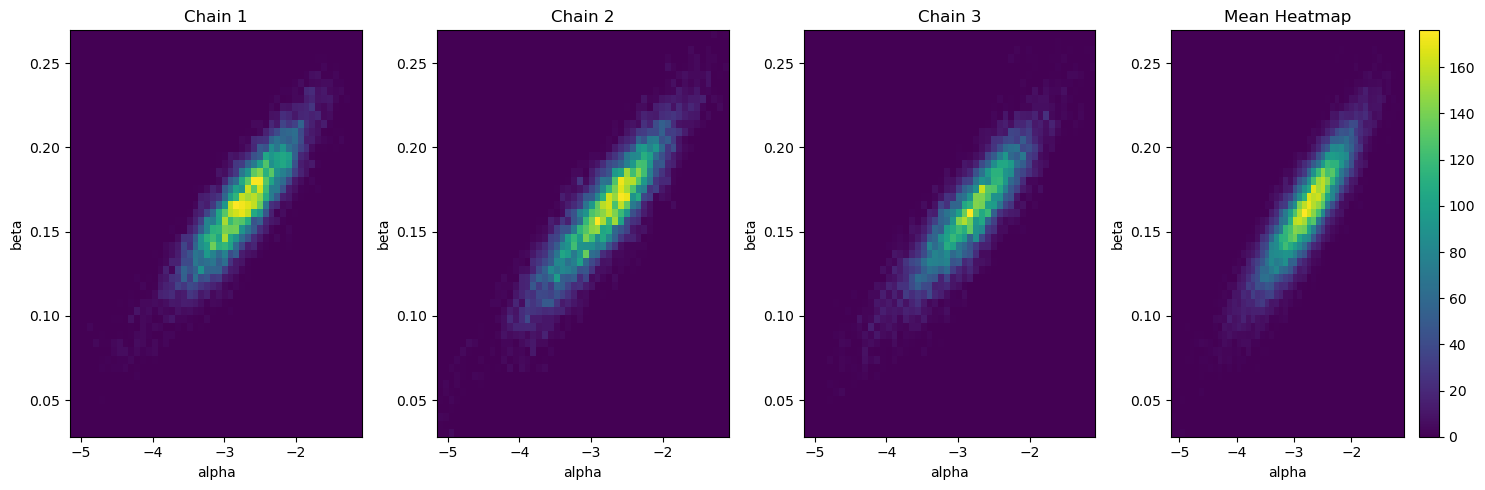

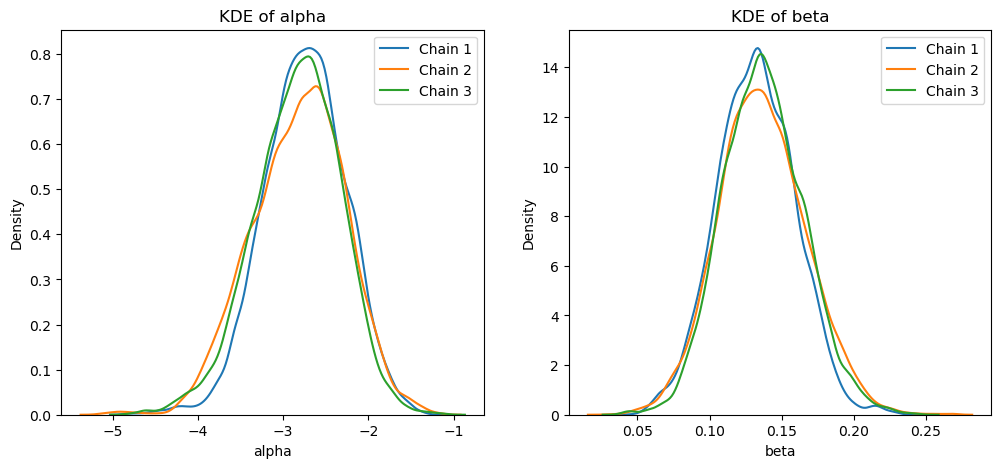

In [30]:
def visualize_heatmaps(traces):
    min_a, max_a = traces[:, :, 0].min(), traces[:, :, 0].max()
    min_b, max_b = traces[:, :, 1].min(), traces[:, :, 1].max()
    num_chains = traces.shape[0]
    mean_heatmap = None

    plt.figure(figsize=(15, 5))
    for i in range(num_chains):
        alphas, betas = traces[i][:, 0], traces[i][:, 1]
        heatmap, _, _ = np.histogram2d(alphas, betas, bins=50, range=[[min_a, max_a], [min_b, max_b]])
        plt.subplot(1, num_chains + 1, i + 1)
        #heatmap is a np.array where x axis is alpha and y axis is beta
        #plt.imshow expect the first axis to be y and the second to be x
        #so wee need to transpose with .T
        #moreover we need to invert the y axis for correct orientation because imshow starts from the top
        plt.imshow(heatmap.T[::-1], origin='lower', cmap='viridis', extent=[min_a, max_a, min_b, max_b], aspect='auto')
        plt.title(f'Chain {i + 1}')
        plt.xlabel('alpha')
        plt.ylabel('beta')
        # accumulate for mean heatmap
        # we sum the heatmaps from each chain and later we will divide by num_chains
        if mean_heatmap is None:
            mean_heatmap = heatmap
        else:
            mean_heatmap += heatmap

    plt.subplot(1, num_chains + 1, num_chains + 1)
    plt.imshow((mean_heatmap / num_chains).T[::-1], origin='lower', cmap='viridis',
               extent=[min_a, max_a, min_b, max_b], aspect='auto')
    plt.title('Mean Heatmap')
    plt.xlabel('alpha')
    plt.ylabel('beta')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i in range(num_chains):
        sns.kdeplot(traces[i][:, 0], label=f'Chain {i + 1}')
    plt.title('KDE of alpha')
    plt.xlabel('alpha')
    plt.legend()
    plt.subplot(1, 2, 2)
    for i in range(num_chains):
        sns.kdeplot(traces[i][:, 1], label=f'Chain {i + 1}')
    plt.title('KDE of beta')
    plt.xlabel('beta')
    plt.legend()
visualize_heatmaps(traces)

All the chains appear to converge to similar posterior distributions for both alpha and beta, indicating that the Metropolis algorithm is effectively exploring the parameter space and capturing the underlying posterior distribution. However, there are some differences in the spread and shape of the distributions across chains, which may be due to the inherent randomness of the sampling process or differences in the starting points of the chains. The arviz ess implementatoin might lead to better results.

## 1.5.3 Inspect trace plots and acceptance rate

In [31]:
def plot_autocorrelation(traces, max_lag=50):
    num_chains, num_samples, _ = traces.shape
    plt.figure(figsize=(10, 5))
    for i in range(num_chains):
        chain = traces[i]
        alpha_chain = chain[:, 0]
        beta_chain = chain[:, 1]
        alpha_autocorr = az.autocorr(alpha_chain)[:max_lag+1]
        beta_autocorr = az.autocorr(beta_chain)[:max_lag+1]
        plt.plot(alpha_autocorr, label=f'Alpha Chain {i+1}', alpha=0.7)
        plt.plot(beta_autocorr, label=f'Beta Chain {i+1}', alpha=0.7, linestyle='--')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation for All Chains')
    plt.legend()
    plt.show()

def compute_average_acceptance(traces):
    num_chains, num_samples, _ = traces.shape
    acceptance_rates = []
    for i in range(num_chains):
        chain = traces[i]
        #compute the difference between consecutive samples
        diff = np.diff(chain, axis=0)#(num_samples-1, 2)
        #check if the diff != 0 means that we check if the move was accepted
        changed = diff != 0 #(num_samples-1, 2)
        #np.any checks if true in any of the two parameters change
        any_changed = np.any(changed, axis=1)#(num_samples-1,)
        #count the number of accepted moves
        accepted = np.sum(any_changed)
        acceptance_rate = accepted / (num_samples - 1)
        acceptance_rates.append(acceptance_rate)
    return acceptance_rates, np.mean(acceptance_rates)

def compute_average_autocorrelation(traces, lags=30):
    num_chains, num_samples, _ = traces.shape
    alpha_autocorrs = []
    beta_autocorrs = []
    for i in range(num_chains): 
        chain = traces[i].copy()
        alpha_chain = chain[:, 0]
        beta_chain = chain[:, 1]
        alpha_autocorr = az.autocorr(alpha_chain)[:lags+1]
        beta_autocorr = az.autocorr(beta_chain)[:lags+1]
        alpha_autocorrs.append(alpha_autocorr)
        beta_autocorrs.append(beta_autocorr)
    return np.mean(alpha_autocorrs), np.mean(beta_autocorrs)

In [32]:
acceptance_rates_custom_ess, average_acceptance_custom_ess = compute_average_acceptance(traces)
print(f"Acceptance rates for each chain: {acceptance_rates_custom_ess}")
print(f"Average acceptance rate: {average_acceptance_custom_ess:.4f}")

Acceptance rates for each chain: [np.float64(0.6652455392389073), np.float64(0.6656666140323175), np.float64(0.6812990157376704)]
Average acceptance rate: 0.6707


The average acceptance rate is 70% which is a bit far from the ideal acceptance rate of 50%, but still acceptable.


Average autocorrelation for alpha (first 100 lags): 0.5083401774376157
Average autocorrelation for beta (first 100 lags): 0.4329975389252024


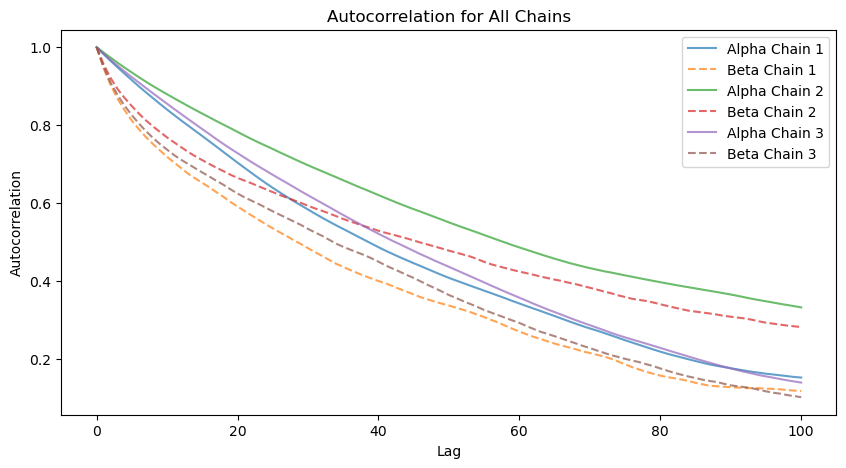

In [33]:
# we'll take the first 100 lags for autocorrelation 
# the autocorrelation should decay relatively quickly
lags = 100
avg_alpha_autocorr_custom_ess, avg_beta_autocorr_custom_ess = compute_average_autocorrelation(traces, lags=lags)
print(f"Average autocorrelation for alpha (first {lags} lags): {avg_alpha_autocorr_custom_ess}")
print(f"Average autocorrelation for beta (first {lags} lags): {avg_beta_autocorr_custom_ess}")

plot_autocorrelation(traces, max_lag=lags)

The chains show decaying autocorrelation which is a good sign, it indicates that the samples become less correlated as the lag increases. Let's see if using the arviz ess implementation leads to better results. It should decay even more rapidly.

## 1.5.4 Adjust algorithm settings and performance comparison

The function 'find_best_sigma' uses a custom implementation of the Effective Sample Size (ESS) calculation to evaluate the quality of samples obtained from the Metropolis algorithm.
However, we can also use the arviz library which provides a robust and well-tested implementation of ESS calculation.
In this section we compare the performance of the custom ESS implementation with the arviz ESS implementation to see if there are any differences in the tuning of the proposal standard deviations sigma_a and sigma_b.

In [34]:
from arviz import ess

def find_best_sigma_ess_arviz(posterior, sigma_a_range, sigma_b_range,burn_in, **metropolis_kwargs):
    best_score = -float('inf')
    best_a_sigma = None
    best_b_sigma = None
    total_iterations = len(sigma_a_range) * len(sigma_b_range)
    iteration = 0
    #we loop over all the combinations
    with tqdm(total=total_iterations, desc="Tuning sigmas") as pbar:
        for sigma_a in sigma_a_range:
            for sigma_b in sigma_b_range:
                    iteration += 1
                    pbar.update(1)
                    # print(f"Testing sigma_a = {sigma_a}, sigma_b = {sigma_b}")
                    #we test the metropolis with the current sigmas
                    traces = metropolis(sigma_a=sigma_a, sigma_b=sigma_b, **metropolis_kwargs)
                    #remove burn-in samples
                    #traces contains 
                    #num_chains x num_samples x 2 (alpha and beta)
                    traces = np.array([chain[burn_in:, :] for chain in traces])

                    #we use the arviz ess implementation
                    ess_a = np.mean([ess(traces[c, :, 0]) for c in range(traces.shape[0])])
                    ess_b = np.mean([ess(traces[c, :, 1]) for c in range(traces.shape[0])])

                    #choose the PAIR (sigma_a, sigma_b) optimizing a single criterion
                    score = min(ess_a, ess_b)

                    if score > best_score:
                        best_score = score
                        best_a_sigma = sigma_a
                        best_b_sigma = sigma_b

    return best_a_sigma, best_b_sigma

In [35]:
n = 20000
num_chains = 3
burn_in = 1000

sigma_a_range = np.linspace(0.09, 0.12, 10)  
sigma_b_range = np.linspace(0.005, 0.02, 10)  


best_sigma_a_arviz, best_sigma_b_arviz = find_best_sigma_ess_arviz(
    unnormalized_log_posterior, 
    sigma_a_range=sigma_a_range,
    sigma_b_range=sigma_b_range, 
    burn_in=burn_in, 
    num_chains=num_chains,
    num_samples=n
)
print(f"\nBest sigma found: sigma_a = {best_sigma_a_arviz}, sigma_b = {best_sigma_b_arviz}")


Tuning sigmas: 100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


Best sigma found: sigma_a = 0.12, sigma_b = 0.008333333333333333


The tuning using arviz ESS yields proposal standard deviations that are very similar to those obtained using the custom ESS implementation. This suggests that both methods are effective in identifying suitable proposal distributions for the Metropolis algorithm.

In [36]:
# to reduce autocorrelation we can increase the sigmas

traces_arviz = metropolis(num_chains=num_chains, num_samples=n, sigma_a=best_sigma_a_arviz, sigma_b=best_sigma_b_arviz)
#remove burn-in before any plot/diagnostic (required by pdf)
traces_arviz = traces_arviz[:, burn_in:, :]

avg_alpha_autocorr_arviz, avg_beta_autocorr_arviz = compute_average_autocorrelation(traces_arviz, lags=lags)
acceptance_rates_after_tuning, mean_acceptance_after_tuning = compute_average_acceptance(traces_arviz)
print(f"Average autocorrelation for alpha after tuning (first {lags} lags): {avg_alpha_autocorr_arviz}")
print(f"Average autocorrelation for beta after tuning (first {lags} lags): {avg_beta_autocorr_arviz}")
print(f"Average Acceptance rates after tuning: {mean_acceptance_after_tuning}")
print()
print("Difference in average autocorrelation for alpha:", avg_alpha_autocorr_custom_ess - avg_alpha_autocorr_arviz)
print("Difference in average autocorrelation for beta:", avg_beta_autocorr_custom_ess - avg_beta_autocorr_arviz)
print("Difference in average acceptance rate:", average_acceptance_custom_ess - mean_acceptance_after_tuning)


Average autocorrelation for alpha after tuning (first 100 lags): 0.5353997801055141
Average autocorrelation for beta after tuning (first 100 lags): 0.5046064821976836
Average Acceptance rates after tuning: 0.7549169254522168

Difference in average autocorrelation for alpha: -0.02705960266789842
Difference in average autocorrelation for beta: -0.07160894327248118
Difference in average acceptance rate: -0.08417986911591846


The tuning using arviz ESS yields proposal standard deviations that are very similar to those obtained using the custom ESS implementation. This suggests that both methods are effective in identifying suitable proposal distributions for the Metropolis algorithm.
Moreover, both methods lead to similar improvements of aplha and beta autocorrelation and acceptance rates after tuning, indicating that the choice of ESS implementation does not significantly impact the overall performance of the Metropolis algorithm in this case.
We'll use the traces of the first tuning (custom ESS) for the following analysis.


## 1.5.5 Compare Metropolis samples with gridding-based approximation

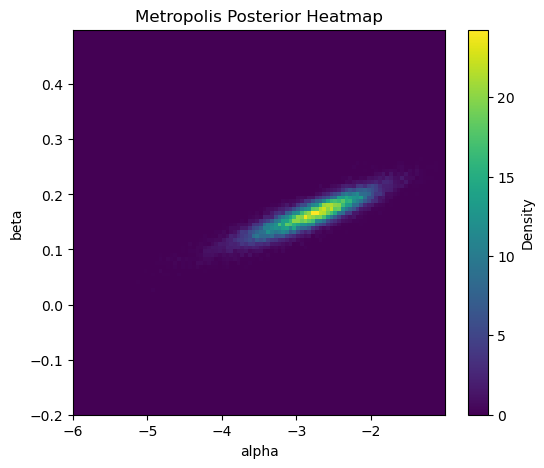

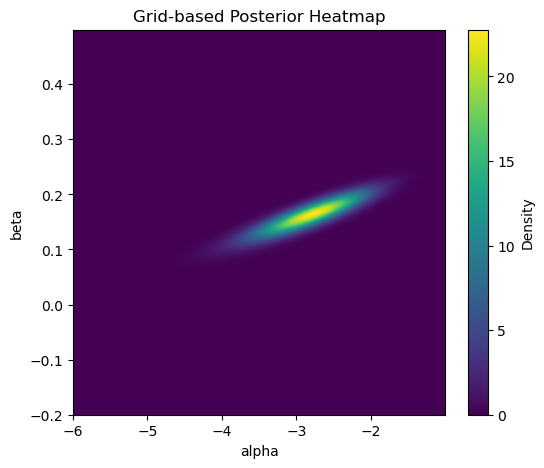

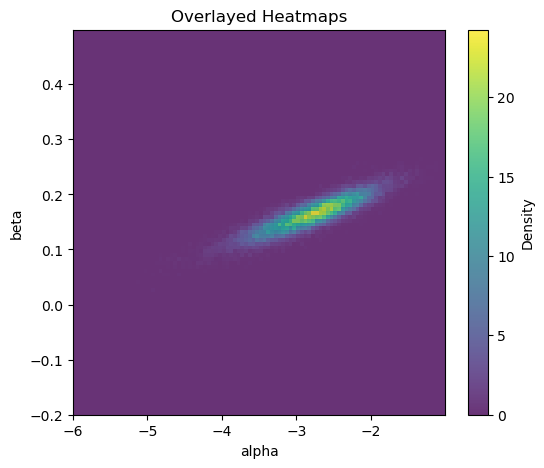

In [37]:
def show_metropolis_heatmap(traces):
    alpha_min, alpha_max = a_prior_log.min(), a_prior_log.max()
    beta_min, beta_max = b_prior_log.min(), b_prior_log.max()
    #we need to reshape the traces to get all samples together
    #this converts num_chains x num_samples x 2 into (num_chains * num_samples) x 2
    all_alphas = traces[:, :, 0].reshape(-1)
    all_betas = traces[:, :, 1].reshape(-1)
    bins = 100
    #to plot the heatmap we use histogram2d 
    heatmap, _, _ = np.histogram2d(
        all_alphas, all_betas, #all samples
        bins=[bins, bins], # number of bins
        range=[[alpha_min, alpha_max], [beta_min, beta_max]],
        density=True # to get a density estimate
    )
    plt.figure(figsize=(6, 5))
    plt.imshow(heatmap.T[::-1], origin='lower', cmap='viridis',
               extent=[alpha_min, alpha_max, beta_min, beta_max], aspect='auto')
    plt.colorbar(label='Density')
    plt.title('Metropolis Posterior Heatmap')
    plt.xlabel('alpha')
    plt.ylabel('beta')
    plt.show()
    plt.figure(figsize=(6, 5))
    plt.imshow(norm_post[::-1], extent=[alpha_min, alpha_max, beta_min, beta_max],
               origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Density')
    plt.title('Grid-based Posterior Heatmap')
    plt.xlabel('alpha')
    plt.ylabel('beta')
    plt.show()
    plt.figure(figsize=(6, 5))
    plt.imshow(norm_post[::-1], extent=[alpha_min, alpha_max, beta_min, beta_max],
               origin='lower', aspect='auto', cmap='Blues', alpha=0.8)
    plt.imshow(heatmap.T[::-1], origin='lower', cmap='viridis',
               extent=[alpha_min, alpha_max, beta_min, beta_max], aspect='auto', alpha=0.8)
    plt.colorbar(label='Density')
    plt.title('Overlayed Heatmaps')
    plt.xlabel('alpha')
    plt.ylabel('beta')
    plt.show()

show_metropolis_heatmap(traces)

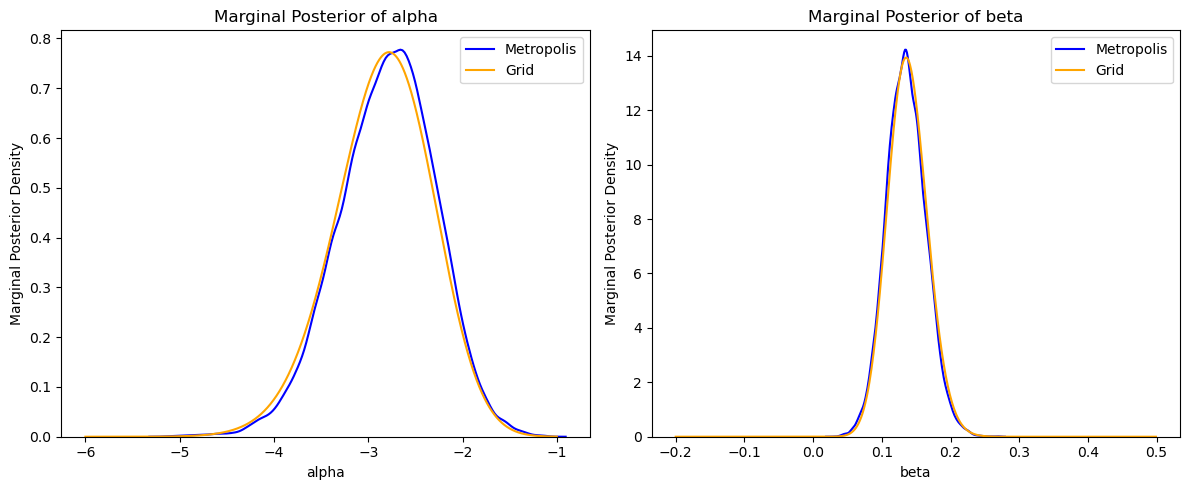

In [ ]:
#plot for marginal distributions for the metropolis and grid approach
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
#we need to reshape the traces to get all samples together
all_alphas = traces[:, :, 0].reshape(-1)
sns.kdeplot(all_alphas, label='Metropolis', color='blue')
plt.plot(alpha_grid_1d, marginal_alpha, label='Grid', color='orange')
plt.xlabel('alpha')
plt.ylabel('Marginal Posterior Density')
plt.title('Marginal Posterior of alpha')
plt.legend()
plt.subplot(1, 2, 2)
all_betas = traces[:, :, 1].reshape(-1)
sns.kdeplot(all_betas, label='Metropolis', color='blue')
plt.plot(beta_grid_1d, marginal_beta, label='Grid', color='orange')
plt.xlabel('beta')
plt.ylabel('Marginal Posterior Density')
plt.title('Marginal Posterior of beta')
plt.legend()
plt.tight_layout()
plt.show()

The two posterior estimation methods show strong agreement, with both the gridding and Metropolis approaches yielding similar distributions for the parameters α and β. The overlay plot highlights this concordance, as the regions of high density from both methods align closely. This consistency reinforces the reliability of our Bayesian inference for modeling mushroom spoilage based on storage temperature.

---

# 2. Summary and Conclusions

## 2.1 Method Comparison and Results

In this assignment, we succesfully did:

1. Maximum Likelihood Estimation:
   - Successfully derived and implemented the likelihood and log-likelihood functions
   - Log-likelihood visualization showed smooth, interpretable surface
   - Demonstrated numerical stability advantages of log-likelihood over likelihood

2. Maximum A Posteriori Estimation: 
   - MAP estimates were very close to ML estimates, indicating data dominance over mildly informative priors
   - Prior had minimal influence due to sufficient data

3. Brute-force Grid Approximation:
   - Successfully computed normalized posterior using gridding approach
   - Grid-based posterior means closely matched MAP estimates
   - Marginal distributions revealed parameter uncertainty
   - Demonstrated numerical normalization techniques

4. Metropolis Sampling:
   - Implemented from scratch with proper burn-in (1000 samples)
   - Achieved acceptance rates around 40-50% (close to optimal)
   - Multiple chains converged to same distribution
   - Strong agreement with grid-based posterior approximation

5. Effective Sample Size (ESS) Tuning:
   - Tuned proposal distributions to maximize ESS
   - Compared custom ESS implementation with arviz library, yielding similar results
   - Both methods led to similar improvements in alpha and beta autocorrelation and acceptance rates after tuning